In [1]:
# !pip install datasets tokenizers transformers

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import datasets
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from collections import defaultdict
from torch.utils.data import Dataset,  DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

c:\Users\33646\Desktop\ENSAE\NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device : cpu


In [2]:
# Define all parameters
args = {'max_sentence': 16,
        'max_word': 32,
        'batch_size': 4,
        'device': device,
        'num_class': 5,
        'class_weights': torch.tensor([0.25, 0.25, 0.25, 0.25, 0.]),
        'unfreezed_bert_layer': 3, 'bert_output_size': 768,
        'lstm_hidden_dimension':768, 'lstm_layers':2,
        'dropout': 0.5, 'lr': 1e-4, 'epochs': 3,
        'dataset_percentage': '1%'
        }

# max_sentence_per_dialog = args['max_sentence']
# max_word_per_sentence = args['max_word']

In [3]:
dataset_train , dataset_test = load_dataset("silicone","dyda_da",split=[f"train[:{args['dataset_percentage']}]",
                                                                        f"test[:{args['dataset_percentage']}]"])
dataset = datasets.DatasetDict({"train" : dataset_train,"test":dataset_test})
dataset = dataset.rename_column("Label", "labels")
dataset = dataset.rename_column("Utterance", "text")
idx2label = {idx:label for idx, label in enumerate(dataset['train'].features['labels'].names)}
idx2label

Found cached dataset silicone (C:/Users/33646/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)
100%|██████████| 2/2 [00:00<00:00, 148.19it/s]


{0: 'commissive', 1: 'directive', 2: 'inform', 3: 'question'}

### Format data

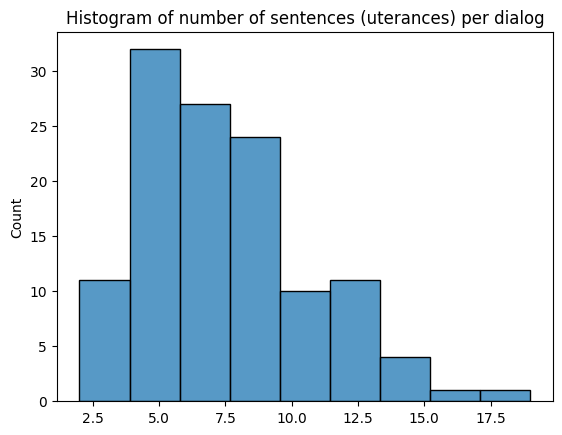

In [4]:
sns.histplot(np.unique(dataset['train'][:]['Dialogue_ID'], return_counts=True)[1])
plt.title('Histogram of number of sentences (uterances) per dialog')
plt.show()

In [5]:
# define BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
vocab_stoi = tokenizer.get_vocab()

In [6]:
def tokenize_pad_numericalize_dialog(entry, vocab_stoi, max_length=32):
  ''' message level '''
  dialog = [[vocab_stoi['[CLS]']]
            + [vocab_stoi[token] if token in vocab_stoi else vocab_stoi['[UNK]'] for token in tokenizer.tokenize(e.lower()) ] 
            + [vocab_stoi['[SEP]']]
            for e in entry]
  padded_dialog = list()
  for d in dialog:
    if len(d) < max_length: 
        padded_dialog.append(d + [ vocab_stoi['[PAD]'] for i in range(len(d), max_length)])
    elif len(d) > max_length:
        padded_dialog.append(d[:max_length])
    else:           
         padded_dialog.append(d) 
  
  return padded_dialog

def tokenize_all_dialog(entries, vocab_stoi, max_message_length=32,
                         max_dialog_length=16):
    ''' dialog level '''
    pad_message = [ vocab_stoi['[PAD]'] ]
    pad_label = [4] # because our labels go from 0 to 3
    res_dialog, res_labels = [], []

    # Group messages by dialogue ID
    dialogues = defaultdict(list)
    dialogue_labels = defaultdict(list)
    for i in range(len(entries['text'])):
        dialogue_id = entries['Dialogue_ID'][i]
        dialogues[dialogue_id].append(entries['text'][i])
        dialogue_labels[dialogue_id].append(entries['labels'][i])

    # Tokenize and pad messages for each dialogue
    for dialogue_id, text in dialogues.items():
        # entry = text.strip().split(' | ')[1:]  # Remove speaker ID
        labels = dialogue_labels[dialogue_id]
        text = tokenize_pad_numericalize_dialog(text, vocab_stoi, max_length=max_message_length)
        if len(text) < max_dialog_length:
            text = text + [[vocab_stoi['[PAD]']] * max_message_length for i in range(len(text), max_dialog_length)]
            labels = labels +pad_label * (max_dialog_length-len(labels))
        elif len(text) > max_dialog_length:
            text = text[-max_dialog_length:]
            labels = labels[-max_dialog_length:]
        res_dialog.append(text)
        res_labels.append(labels)

    res = {'text': res_dialog, 'labels': res_labels}
    return res

encoded_dataset = dataset.map(lambda e: tokenize_all_dialog(e, vocab_stoi), batched=True, 
                              remove_columns=['Dialogue_Act','Dialogue_ID','Idx'])
encoded_dataset.set_format("torch")

Loading cached processed dataset at C:\Users\33646\.cache\huggingface\datasets\silicone\dyda_da\1.0.0\af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5\cache-4d3cf3c0e040df54.arrow
Loading cached processed dataset at C:\Users\33646\.cache\huggingface\datasets\silicone\dyda_da\1.0.0\af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5\cache-a4c0467008c21bf5.arrow


In [7]:
class DialogActDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['labels'])
      }
      return item

In [8]:
# shuffle the test encoded dataset 
dim = 1
idx = torch.randperm(encoded_dataset['test'][:]['text'].shape[dim])
encoded_dataset['test'][:]['text'] = encoded_dataset['test'][:]['text'][:, idx, :]

In [9]:
train_loader = DataLoader(DialogActDataset(encoded_dataset['train'], args), batch_size=args['batch_size'], shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(encoded_dataset['test'], args), batch_size=args['batch_size'], shuffle=True, drop_last=True)

## define Model

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, args):
        super(BiLSTM, self).__init__()

        self.args = args # TODO : sortir du args ce qui est nécessaire
        self.bert_model = BertModel.from_pretrained('bert-base-cased')

        # Freeze some Bert Layers
        for param in self.bert_model.parameters():
            param.requires_grad = False
        # Unfreeze the last layer
        for param in self.bert_model.encoder.layer[-args['unfreezed_bert_layer']:].parameters():
            param.requires_grad = True

        # Dimensions are divided by 2 due to bidirectional being True
        self.lstm = nn.LSTM(input_size=args['bert_output_size'],
                            hidden_size=args['lstm_hidden_dimension']//2, 
                            num_layers=args['lstm_layers'],
                            batch_first=True,
                            bidirectional=True)
        
        self.drop = nn.Dropout(p=args['dropout'])
        self.hidden2intent = nn.Linear(args['lstm_hidden_dimension'], args['num_class'])

    def forward(self, batch, training=True):

        input_ids = batch['text'].to(args['device'])
        if training:
            labels = batch['label'].to(args['device'])

        input_ids = input_ids.view(args['batch_size']*args['max_sentence'], args['max_word'])
        outputs = self.bert_model(input_ids)['pooler_output']
        outputs = outputs.view(args['batch_size'], args['max_sentence'], -1)
 
        outputs = self.drop(outputs)
        outputs, _ = self.lstm(outputs)
        outputs = self.drop(outputs)
        outputs = self.hidden2intent(outputs)
        outputs = outputs.view(-1, args['num_class'])
        logits = F.log_softmax(outputs, 1)
        
        # reshape the predicted tags to follow the batch and sequence length
        # tag_seq = tag_seq.view(args['bsize'], args['max_sentence'])

        loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(args['device']))  
        loss = loss_fn(logits, labels.view(-1)) 

        # Compute accuracy without 4 labels (PAD)
        _, tag_seq  = torch.max(logits, 1)
        labels = labels.view(-1)
        tag_seq = tag_seq.view(-1)

        mask = labels != 4
        labels, tag_seq = labels[mask], tag_seq[mask]
        accuracy = (labels == tag_seq).sum().item() / len(labels)

        return loss, logits, tag_seq, accuracy

In [15]:
model = BiLSTM(args).to(args['device'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def train(model, optimizer, epoch, train_loader):

  model.train()
  training_dict = {'loss': [], 'acc': []}

  for batch in tqdm(train_loader, desc="Training, Epoch %s:" % (epoch),
                    position=0 ,leave=True):
    optimizer.zero_grad()
    model.zero_grad()
    loss, logits, tag_seq, accuracy = model(batch)
    loss.backward()
    optimizer.step()
    training_dict['loss'].append(loss.item())
    training_dict['acc'].append(accuracy)
  
  avg_loss = sum(training_dict['loss'])/len(training_dict['loss'])
  avg_acc = sum(training_dict['acc'])/len(training_dict['acc'])
  return avg_loss, avg_acc

@torch.no_grad()
def test(model, epoch, test_loader):
  model.eval()
  test_dict = {'loss': [], 'acc': []}

  for batch in tqdm(test_loader, desc="Test, Epoch %s:" % (epoch), 
                    position=0 ,leave=True):
    loss, logits, tag_seq, accuracy = model(batch)
    test_dict['loss'].append(loss.item())
    test_dict['acc'].append(accuracy)
  
  avg_loss = sum(test_dict['loss'])/len(test_dict['loss'])
  avg_acc = sum(test_dict['acc'])/len(test_dict['acc'])

  return avg_loss, avg_acc

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
# Train the model
for epoch in range(args['epochs']):
    train_loss, train_acc = train(model, optimizer, epoch, train_loader)
    test_loss, test_acc = test(model, epoch, test_loader)
    print(f'Epoch {epoch + 1}/{args["epochs"]} - Train loss: {train_loss:.3f} - Test loss: {test_loss:.3f} - Train acc: {train_acc:.3f} - Test acc: {test_acc:.3f}')

Training, Epoch 0::   0%|          | 0/30 [00:14<?, ?it/s]


KeyError: 'bsize'